<a href="https://colab.research.google.com/github/ancastillar/ML_WORKSHOP/blob/main/Classification_task_ML_Project_IRIS_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Non-linear classification: Decision Tree & Random Forest
We first define some libraries and functions that we are going to use during the session:

In [ ]:
# https://pypi.python.org/pypi/pydot-
!apt install graphviz
!pip install graphviz
!pip install pydot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn import datasets
from sklearn.datasets import make_moons
import graphviz 
from sklearn.tree import export_graphviz
import pydot
import pandas as pd
import seaborn as sns
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D

# Function for displaying a 2D data set
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function for display of the decision surface of a classifier
def plot_decision_region(X, pred_fun):
    print(X.shape)
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

# Decision Trees

We presentnonlinear classification algorithm based on decision trees. Decision trees are very intuitive, since they encode a series of "**if this**" or "**if not then**" choices, much like a person would make a decision. The great advantage of this technique is that these choices can be learned automatically from the data.

## Example

Consider the following decision tree. This decision tree describes a series of choices that seek to determine whether to wait (**T**) or not (**F**) for a table in a restaurant.

<img src="https://github.com/fagonzalezo/iis-2020-1/raw/master/imgs/decisiontree2.png">

Based on the above decision tree, I can make the decision whether to wait or not, using some simple classification rules, e.g.:

*  **If** Customers = "Full" **AND** EstimatedWait = "10-30" **AND** Hungry = "No" **Then** Wait="YES"
* **If** Customers = "Some" **Then** Wait="YES"
*  **If** Clients = "Full" **Y** EstimatedWait = ">60" **Then** Wait="NO"

## Benefits

* Input data require very little preprocessing. Decision trees can work with variables of different types (continuous and variable) and are **invariant to feature scaling**. 
* Models are easy to interpret, trees can be visualized.
* The computational cost of using the tree to predict the category of an example is minimal compared to other techniques (Logarithmic time).

## Cons

* Can be so complex, that the data set is memorized, therefore does not generalize as well (**Overfitting**).
* Are very sensitive to class imbalance (**Bias**).

## How is the tree constructed? - Basic algorithm
* The tree is built from top to bottom recursively in a divide and conquer fashion.
* At the beginning, all training examples are at the root.
* Attributes are categorical (in case of continuous attributes, they are discretized in advance).
* The examples are distributed recursively according to the selected attribute. 
* Test attributes are selected based on a heuristic or statistical measure (e.g. **information gain**).
* Stops until there are only examples of one class in each leaf node or the maximum depth has been reached.


## How to select an attribute? How to measure if a partition is good?

An ideal partition is one that divides samples of the same class into a node. Let's see what happens if we use the variable **Client** to partition our dataset.

<img src="https://github.com/fagonzalezo/iis-2020-1/raw/master/imgs/split_clients.png">

Now, let's look at what happens when we partition the data set using the **Restaurant Type** variable.

<img src="https://github.com/fagonzalezo/iis-2020-1/raw/master/imgs/split_type.png">



**Which variable is better?**
We calculate first the Gini (Measure of impurity) for each leaf:

Gini  = 1-(the probability of yes $)^2$- (the probability of no $)^2$ 

Then we calculate the Gini of the Node:

Gini = $w_r* gini_r + w_f* gini_f$


**we choose the variable with the LOWEST GINI!**

## Implementation in Scikit-Learn: Iris Dataset

The implementation of Scikit-Learn is achieved with the `DecisionTreeClassifier` class.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy')

**We loaded dataset using IRIS.**

NOTE: Iris dataset includes three iris species with 150 samples each as well as some properties about each flower. One flower species is linearly separable from the other two, but the other two are not linearly separable from each other.

In [ ]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names )
y = iris.target
iris_df["class_iris"] = y

**BASIC EDA**

In [ ]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class_iris
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


**Distribution of the target**

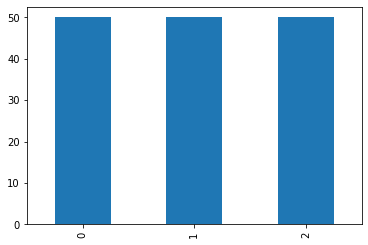

In [ ]:
iris_df.class_iris.value_counts().plot(kind="bar")

*We have a pettry balanced data, but usually this is NOT the reality*

**Exploring Distribution and correlations**

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

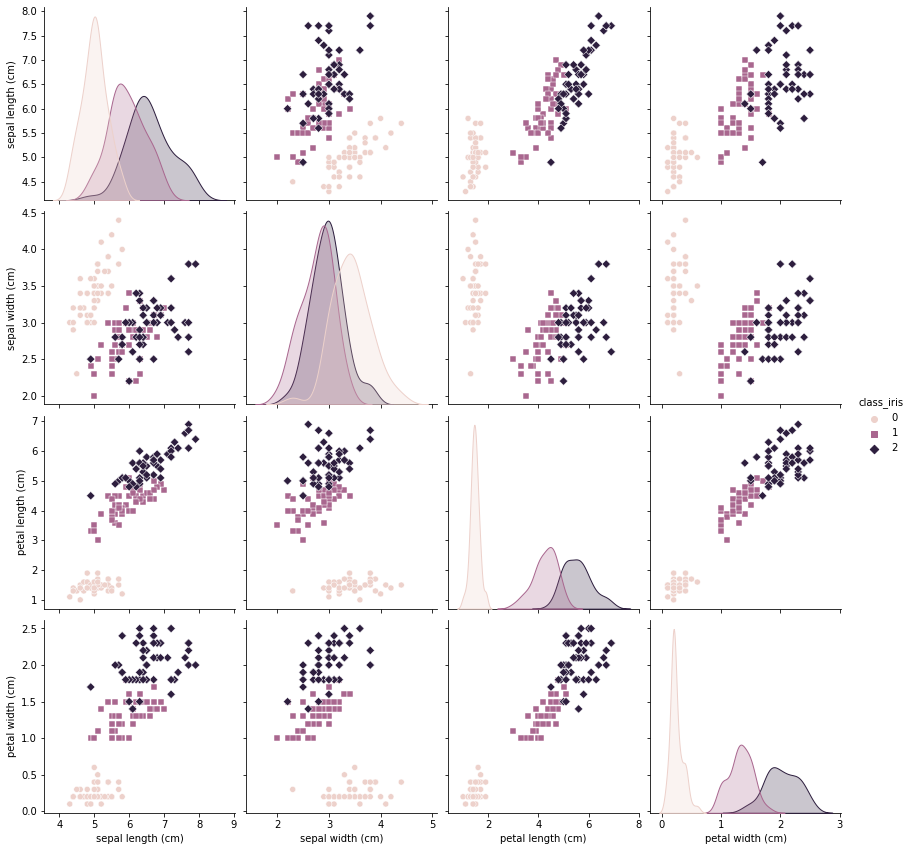

In [ ]:
plt.figure()
sns.pairplot(iris_df, hue = "class_iris", size=3)
plt.show()

In [ ]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class_iris
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


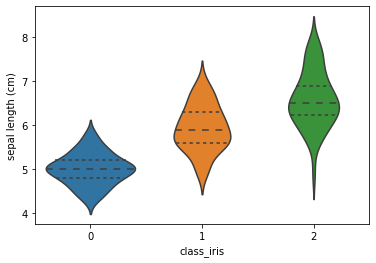

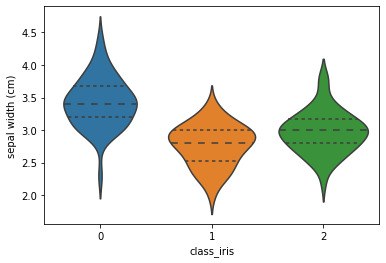

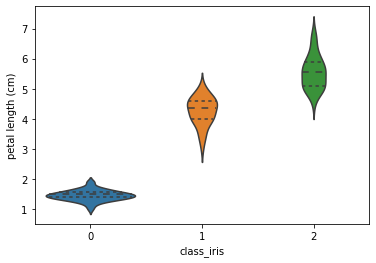

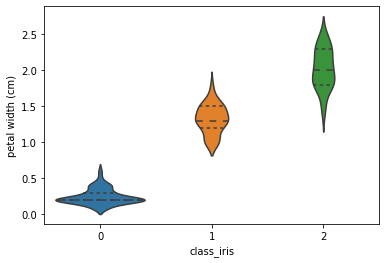

In [ ]:
g = sns.violinplot(x='class_iris', y='sepal length (cm)', data=iris_df, inner='quartile')
plt.show()
g = sns.violinplot(x='class_iris', y='sepal width (cm)', data= iris_df, inner='quartile')
plt.show()
g = sns.violinplot(x='class_iris', y='petal length (cm)', data= iris_df, inner='quartile')
plt.show()
g = sns.violinplot(x='class_iris', y='petal width (cm)', data= iris_df, inner='quartile')
plt.show()

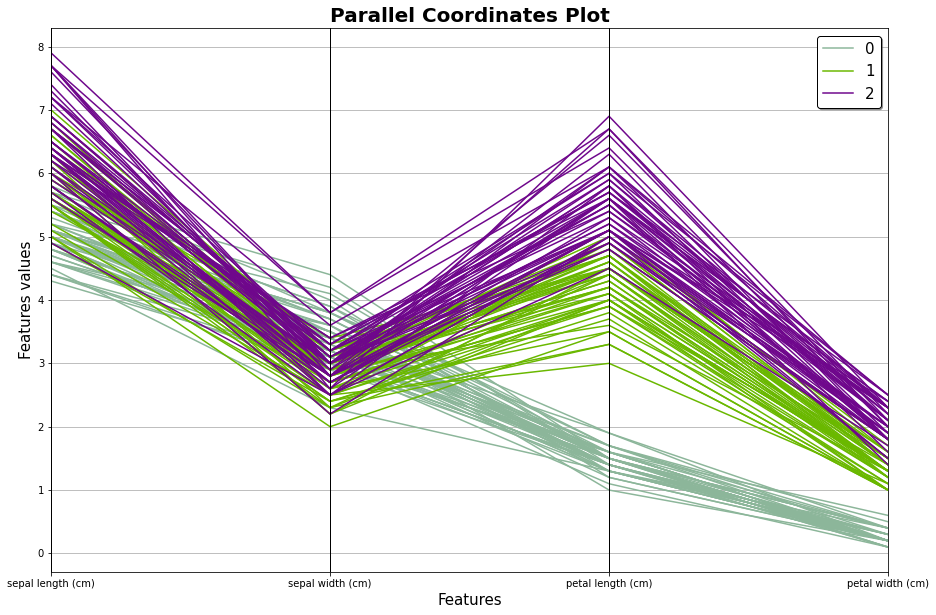

In [ ]:
plt.figure(figsize=(15,10))
parallel_coordinates(iris_df, "class_iris")
plt.title('Parallel Coordinates Plot', fontsize=20, fontweight='bold')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features values', fontsize=15)
plt.legend(loc=1, prop={'size': 15}, frameon=True,shadow=True, facecolor="white", edgecolor="black")
plt.show()

**Boxplot**

<Figure size 432x288 with 0 Axes>

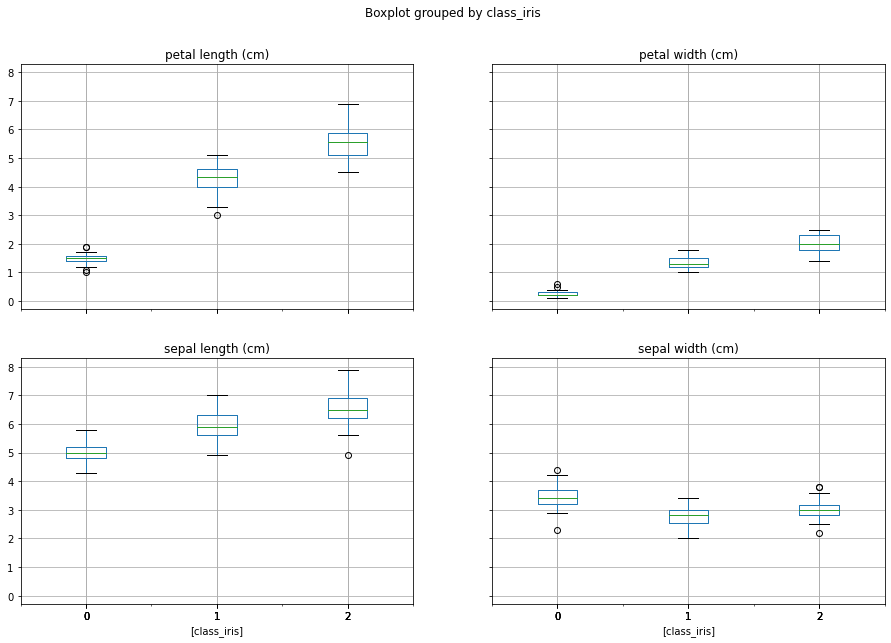

In [ ]:
plt.figure()
iris_df.boxplot(by="class_iris", figsize=(15, 10))
plt.show()

## Parameteres

In [ ]:
iris = datasets.load_iris()
X = iris.data[:,[0, 2]] 
y = iris.target

DecisionTreeClassifier supports several parameters such as:
* `max_depth`: Maximum depth of the tree.
* `criterion`: Measure to determine the quality of the partitioning generated by an attribute. Supports GINI coefficient and entropy.
* `min_samples_split`: Controls the minimum number of samples that must be in a node after a partition.
* `min_samples_leaf`: Controls the minimum number of samples that must be in a leaf node.

In [ ]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int or None, optional (default=None)
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int, float, optional (default=2)

In [ ]:
classifier.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [ ]:
classifier = classifier.fit(X, y)

**We visualize the decision surface of the classifier**

(150, 2)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


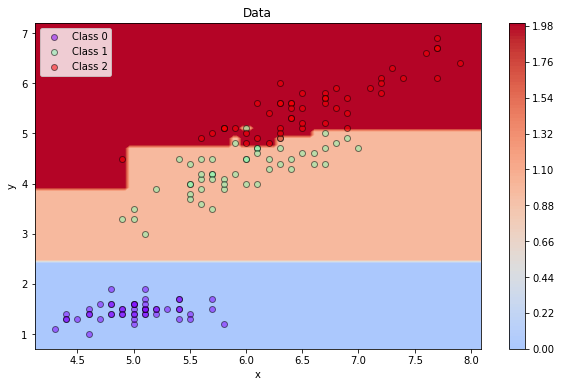

In [ ]:
pl.figure(figsize = (10, 6))    
plot_decision_region(X, gen_pred_fun(classifier))
plot_data(X, y)

In [ ]:
print('Error: {}'.format(1-classifier.score(X, y)))

Error: 0.00666666666666671


## Visualization

The learned decision tree can be visualized using `graphviz`. On Ubuntu, it is recommended to install it using both lines:
* `conda install graphviz`
* `sudo apt-get install graphviz`.

Next, we are going to use the complete IRIS dataset (using the four features) and train a decision tree.

In [ ]:
X = iris.data
y = iris.target

classifier = DecisionTreeClassifier(criterion='entropy')
classifier = classifier.fit(X, y)

We use `graphviz` to visualize the generated tree. `graphviz` supports class and feature names as parameters

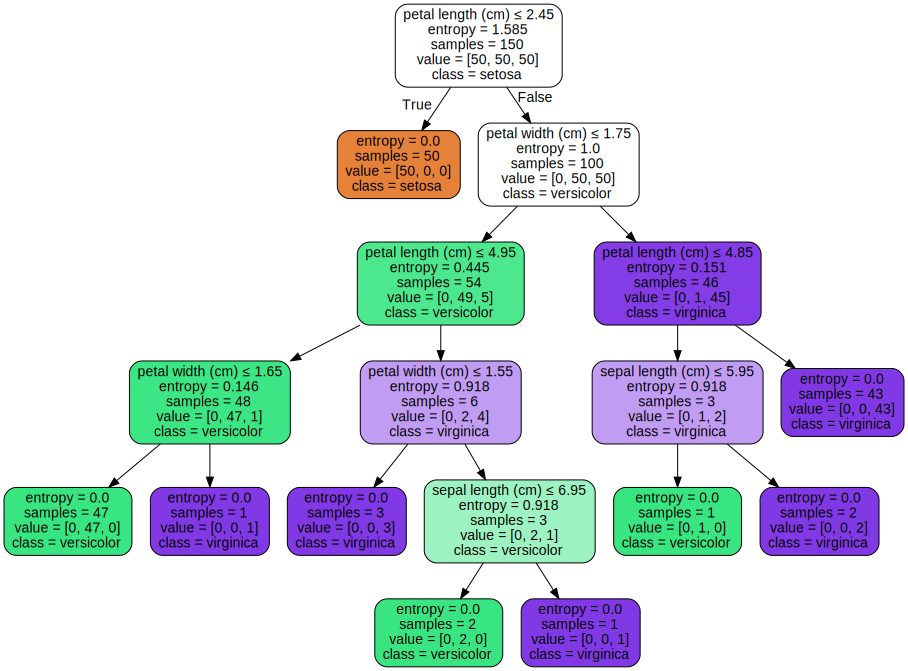

In [ ]:
from IPython.display import SVG
dot_data = export_graphviz(classifier, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

## Importance of variables

One of the advantages of using decision trees is that it allows us to determine the importance of each feature, based on the impurity index used. Scikit-Learn allows us to access the importance of each feature by calling `.feature_importances_`. This importance quantifies how much each feature contributes to improve the performance of the tree.

In [ ]:
classifier.feature_importances_

array([0.02666667, 0.        , 0.05072262, 0.92261071])

In [ ]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

## Complexity evaluation using `DecisionTreeClassifier`.

To evaluate the complexity, let's estimate the optimal depth of the tree.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

Let's explore the following maximum depth values:
* $[1, 2, 3, 3, 20]$

In [ ]:
train_error = []
generalization_error = []
max_depth_values = list(range(1, 21, 1))

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    train_error.append(1 - decision_tree.score(X_train, y_train))
    generalization_error.append(1 - decision_tree.score(X_test, y_test))

We visualize the training error versus generalization error curve.

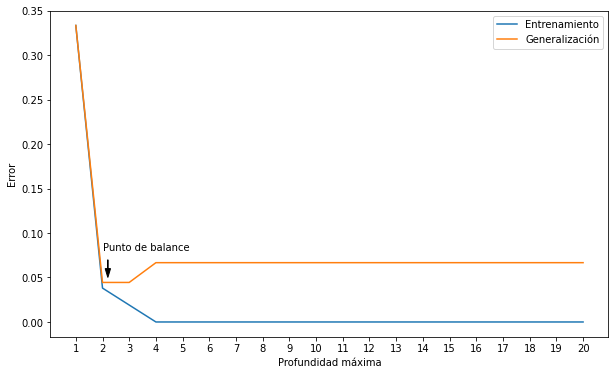

In [ ]:
pl.figure(figsize = (10, 6))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.arrow(2.2, 0.07, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(2, 0.08, 'Punto de balance')
pl.legend();

In [ ]:
X = iris.data
y = iris.target

classifier = DecisionTreeClassifier(criterion='entropy', max_depth=2)
classifier = classifier.fit(X, y)

We use `graphviz` to visualize the generated tree. `graphviz` supports class and feature names as parameters

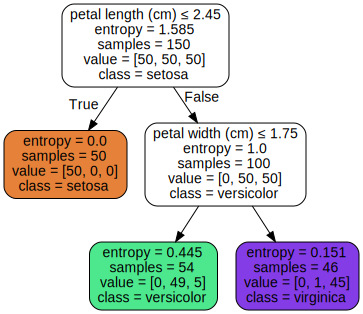

In [ ]:
from IPython.display import SVG
dot_data = export_graphviz(classifier, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

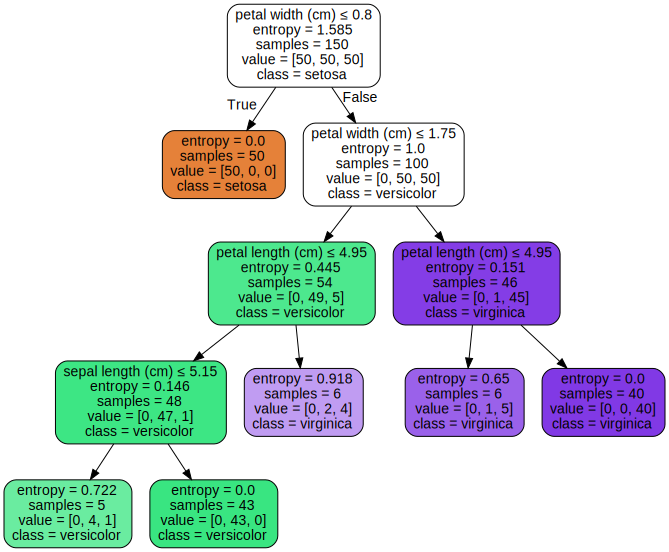

In [ ]:
X = iris.data
y = iris.target

classifier = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)
classifier = classifier.fit(X, y)

from IPython.display import SVG
dot_data = export_graphviz(classifier, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

In [ ]:
train_error = []
generalization_error = []
min_samples_leaf_values = list(range(1, 21, 1))

for samples in min_samples_leaf_values:
    decision_tree = DecisionTreeClassifier(min_samples_leaf=samples)
    decision_tree.fit(X_train, y_train)
    train_error.append(1 - decision_tree.score(X_train, y_train))
    generalization_error.append(1 - decision_tree.score(X_test, y_test))

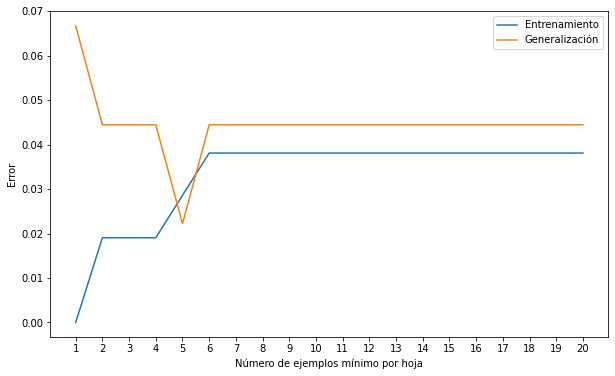

In [ ]:
pl.figure(figsize = (10, 6))

pl.plot(min_samples_leaf_values, train_error, label="Entrenamiento")
pl.plot(min_samples_leaf_values, generalization_error, label="Generalización")
pl.xticks(min_samples_leaf_values)
pl.xlabel("Número de ejemplos mínimo por hoja")
pl.ylabel("Error")
pl.legend();

## The problem with Desicion Trees and the solution: **RANDOM FOREST**


Problems:
* In some cases, decision tree-generated decision boundaries (parallel to the axes) are not flexible enough to capture the nonlinearity of the data set.

* On the other hand, decision trees can create very specific decision rules that fit too closely to the training data.

* They are also sensitive to small variations in the data that can result in totally different trees. This is a problem when doing k-fold cross-validation.

**How to solve this problem?**


We are going to use a strategy known as *ensemble of classifiers*. An ensemble of classifiers combines different learning algorithms to obtain better predictive performance. In the following, we present a way how to build an ensemble of classification trees. Different trees are trained on different subsets of the training data. Subsequently, when a prediction is to be made for a new data, the predictions of all the trees are obtained and the class with the highest predicted frequency is returned.

<img src="https://github.com/fagonzalezo/iis-2020-1/raw/master/imgs/ensemble2.svg">

The technique in the figure is known as *bagging*. In the following example we are going to use the `BaggingClassifier` function which trains a model using this strategy. The parameters received by the function are the following:
* `base_estimator`: Consists of the base estimator to be trained on the different subsets of the training data set.
* `n_estimators`: It is the number of base estimators to be used for the *bagging* strategy.


## Intuition behind RandomForests

Random Forest is an **assembly** technique that combines different decision trees. These trees are trained on different samples from the data set, these trees may overfit, however combining their predictions results in a classifier with lower overfit. To understand the idea of how this algorithm is constructed, suppose we train the following trees to determine whether a person is sick or healthy:

<img src="https://github.com/fagonzalezo/iis-2020-1/raw/master/imgs/RF.png">



## Random Forest basic algorithm

Unlike the common decision tree, Random Forest trees are trained in a different way. The basic training algorithm is presented below:

1. For each tree, the following procedure is performed:
    * A sample with replacement of size *n* is chosen from the training set.
    * A tree is trained on the training set of *m* variables.
    * A tree is trained on the sample using the *m* variables by repeating the following steps:
        * Choose the variable (and threshold) that generates the best partition.
        * The data is divided into two subsets according to the variable and the threshold.
        * If a stopping criterion is not satisfied, this procedure is applied recursively on the subsets.
2. Once each tree has been trained, the tree assembly is generated.

## Implementation in Scikit-Learn

The implementation in Scikit-Learn allows us to control the following parameters:
* `n_estimators`: Number of trees to be trained.
* `max_features`: Number of random m variables taken into account for the construction of each tree.

A large number of trees results in good performance at the cost of computational cost. Both parameters should be explored using cross-validation. In the following, we will use the `wine` data set.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

**Employ the Iris DataSet and train your own  Random Forest algorithm**

Split the data

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

Define the parameters values to evaluate the Random Forest

In [ ]:
max_features_params = [np.round(10**-1 * i, decimals=1) for i in range(1, 11, 1)]
param_grid = {'n_estimators': [2**i for i in range(2, 12, 1)], 'max_features': max_features_params}

 Your turn...

Fit...

In [ ]:
clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=1, n_jobs=-1, cv=5)
clf.fit(,) #####################################Complete

Evaluate.....


In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_features']),
                                                    len(param_grid['n_estimators']))


clf.best_params_ ######Theeee best modeel that minimize the loss function

 clf.score(X_test, y_test)##### Evaluate on test


Feature importance....



In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("F.I:")

for f in range(X_train.shape[1]):
    print("Feature %s (%f)" % (df.columns[int(1+indices[f])], importances[indices[f]]))

**HINT**

Please, check this for plot the surfaces desicion: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html